In [15]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score

### 读取数据

In [16]:
df = pd.read_csv('../data/processed.csv')
df_test = pd.read_csv('../data/processed_test.csv')
df_submit = pd.read_csv('../data/submission.csv')
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285285 entries, 0 to 285284
Columns: 356 entries, OPEN_ORG_NUM to L6_CHANNEL_AUTO_DOUTTA_AVGCNT
dtypes: float64(260), int64(96)
memory usage: 774.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189766 entries, 0 to 189765
Columns: 355 entries, OPEN_ORG_NUM to L6_CHANNEL_AUTO_DOUTTA_AVGCNT
dtypes: float64(259), int64(96)
memory usage: 514.0 MB


In [19]:
# 归一化
for col in df.columns:
    if(col == 'bad_good'):
        continue
    df[col] = df[col].astype(float)
    df_test[col] = df_test[col].astype(float)
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    df_test[col] = (df_test[col] - df_test[col].min()) / (df_test[col].max() - df_test[col].min())

### 查看相关性

In [20]:
target_corr = []
for col in df.columns:
    if col != 'bad_good':
        target_corr.append((col, abs(df['bad_good'].corr(df[col]))))
target_corr.sort(key=lambda item: item[1])
cols = [item[0] for item in target_corr]
corrs = [item[1] for item in target_corr]
nums = [np.sum(np.array(corrs) > 0.001 * times) for times in range(1, 11)]

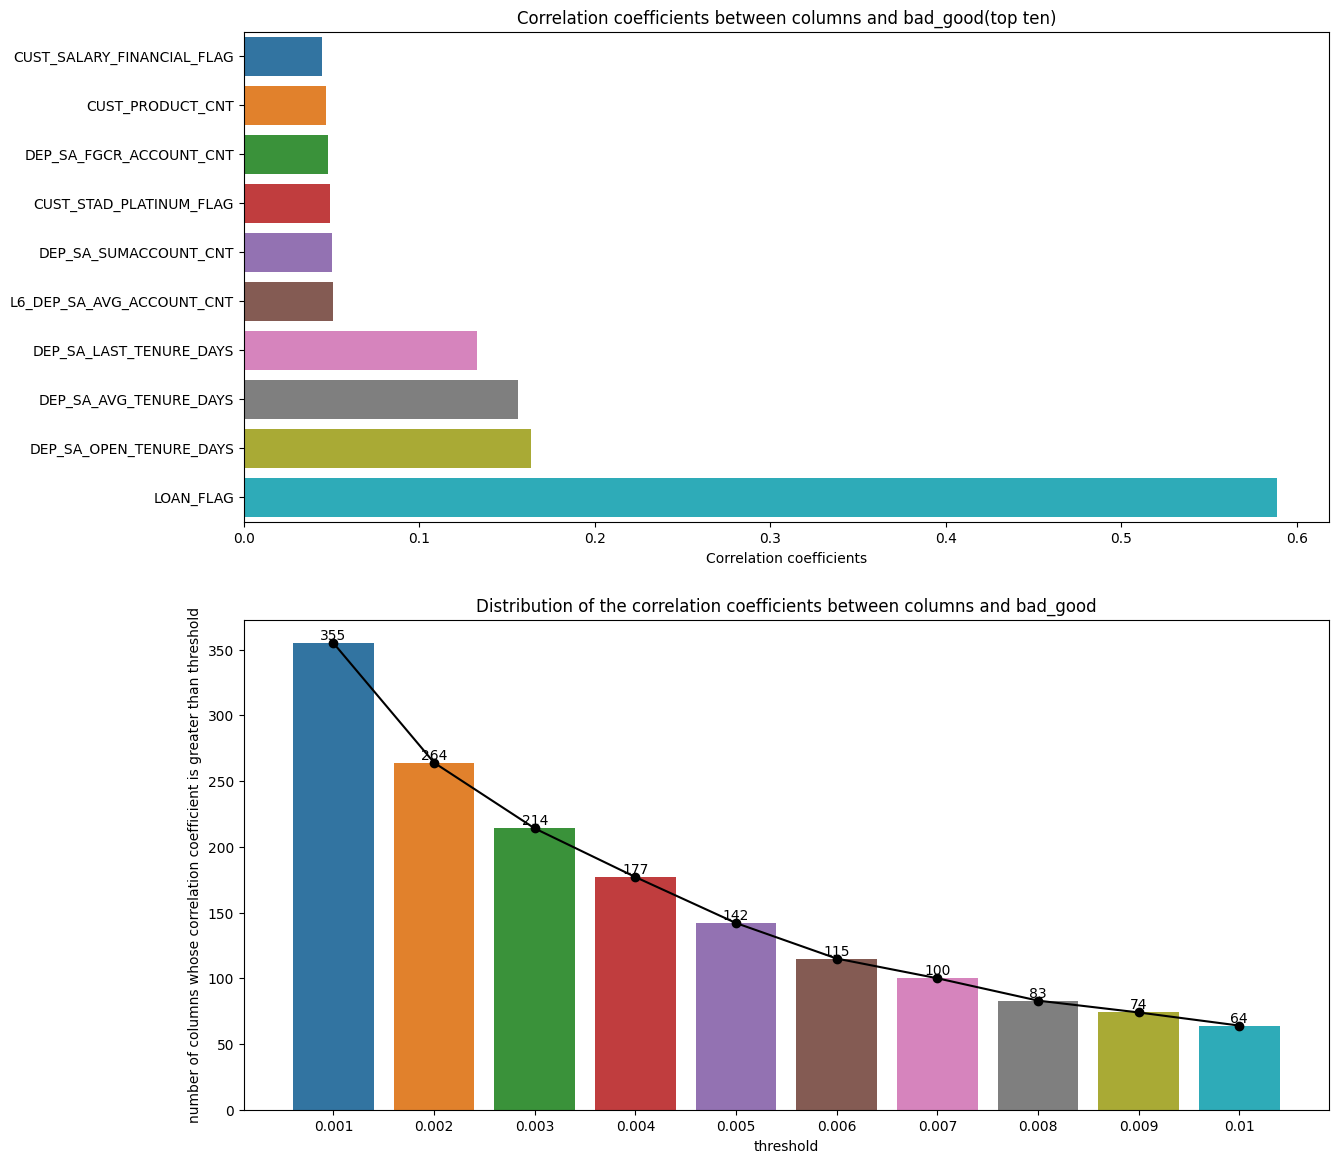

In [21]:
plt.figure(figsize = (14, 14))
plt.subplot(211)
sns.barplot(x = corrs[-10:], y = cols[-10:], orient='h')
plt.title('Correlation coefficients between columns and bad_good(top ten)')
plt.xlabel('Correlation coefficients')

plt.subplot(212)
threshold = [str(round(0.001 * times, 3)) for times in range(1, 11)]
sns.barplot(x = threshold, y = nums)
plt.plot(threshold, nums, marker='o', color='black')
for i in range(len(threshold)):
    plt.text(threshold[i], nums[i] + 0.5, str(nums[i]), ha='center', va='bottom')
plt.title('Distribution of the correlation coefficients between columns and bad_good')
plt.xlabel('threshold')
plt.ylabel('number of columns whose correlation coefficient is greater than threshold')
plt.show()

### 划分训练集和验证集

In [24]:
# 暂时选取前100列
data = df[cols[-100: ] + ['bad_good']].copy()
X_test = df_test[cols[-100: ]].copy()
train_data, valid_data = train_test_split(data, test_size=0.01)
X_train, y_train = train_data[cols[-100: ]], train_data['bad_good']
X_valid, y_valid = valid_data.iloc[cols[-100: ]], valid_data['bad_good']

### 训练MLP&交叉验证后在测试集上预测

In [ ]:
# 经测试，MLP网络结构如果较为简单或最大迭代步数较少
# 会由于目标列正负样本不平衡导致预测全0
model = MLPClassifier(hidden_layer_sizes=(10, 10, 5), solver='adam', max_iter=500)
model.fit(X_train, y_train)
score = cross_val_score(model, X_valid, y_valid, cv=5)
print(score.mean())     # average accuracy on valid dataset

y_pred = model.predict(X_test)
df_pred = pd.DataFrame({'bad_good': y_pred})
df_pred.insert(0, 'CUST_ID', df_submit['CUST_ID'])

In [ ]:
df_pred['bad_good'].value_counts()

In [ ]:
df_pred.to_csv('result/result_MLP.csv', mode='w', index=False)
# 该文件提交后得分xxxxxxxx，说明预处理步骤具有一定可行性